# Evaluation Metrics & Experimental Process

In this step we will implement the main metrics used to evaluate recommender systems.
We also will realize specific analyzes about the RS implemented in the last classes.
This kind of experimentation is similar to what is expected from you in the final project.
For this reason, you must do:

- Read the train and test files
- Implement the main evaluation metrics
- Plot graphics to analyze the RSs' behavior
- Answer few questions about them

In [1]:
# import libs
import operator
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from collections import OrderedDict

# useful command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams.update({'font.size': 14})

## Reading train and test files

You can read this file as you prefer. I propose to read the files by the pandas' library and create the sparse matrix after it.

In [ ]:
df_train = pd.read_csv(
    "../Unidade 1/Dataset/ML-1M/trainSet.txt",
    sep="::",
    names=["userId", "itemId", "rating", "timestamp"],
)
df_test = pd.read_csv(
    "../Unidade 1/Dataset/ML-1M/testSet.txt",
    sep="::",
    names=["userId", "itemId", "rating", "timestamp"],
)


df_train.head()

df_test.head()

C:\Users\jean_\AppData\Local\Temp\ipykernel_24864\1749714384.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train = pd.read_csv(
C:\Users\jean_\AppData\Local\Temp\ipykernel_24864\1749714384.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_test = pd.read_csv(


,userId,itemId,rating,timestamp
0,1,1193,5.0,978300760.0
1,1,661,3.0,978302109.0
2,1,914,3.0,978301968.0
3,1,3408,4.0,978300275.0
4,1,1197,3.0,978302268.0


,userId,itemId,rating,timestamp
0,1,2355,5.0,978824291.0
1,1,595,5.0,978824268.0
2,1,2687,3.0,978824268.0
3,1,48,5.0,978824351.0
4,1,745,3.0,978824268.0


## Creating Sparse Matrix for these sets

I propose to use the csr_matrix from scipy.

In [3]:
# Select users, items and ratings logs (i.e., all information from each column)
users = df_train["userId"]
items = df_train["itemId"]
ratings = df_train["rating"]

In [4]:
# Define the matrix dimensions based on the max index related to users and items
nb_users = max(users)
nb_items = max(items)

In [5]:
# Creating matrix of ratings
train_matrix = csr_matrix((ratings, (users, items)), shape=(nb_users+1, nb_items+1))

train_matrix.shape

(6041, 3953)

In [6]:
# Select users, items and ratings logs from test (i.e., all information from each column)
users = df_test["userId"]
items = df_test["itemId"]
ratings = df_test["rating"]

In [7]:
# Creating matrix of ratings
test_matrix = csr_matrix((ratings, (users, items)), shape=(nb_users+1, nb_items+1))

test_matrix.shape

(6041, 3953)

## Reading the recommendation

This function is used to read the recommendations generated by each RS.

In [8]:
def readRecommendation(file_name):
    
    recommendations = {}
    file_in = open(file_name, 'r')
    
    # for each line
    for row in file_in:
        row = row.rstrip()
        # extracting userId
        values = row.split("\t")
        userId = int(values[0])
        recommendations[userId] = []
        # extracting items
        values[1] = values[1].replace('[','')
        values[1] = values[1].replace(']','')
        recList = values[1].split(',')
        # saving items
        for tupla in recList:
            v = tupla.split(':')
            recommendations[userId].append(int(v[0]))
    
    file_in.close()
    
    return recommendations

Reading all files saved before.

In [12]:
rec_MostPopular = readRecommendation("../Unidade 1/Dataset/recList_MostPopular.txt")
rec_BestRated = readRecommendation("../Unidade 1/Dataset/recList_BestRated.txt")
rec_Rocchio = readRecommendation("../Unidade 1/Dataset/recList_Rocchio.txt")
rec_PureSVD = readRecommendation("../Unidade 1/Dataset/recList_PureSVD.txt")

In [13]:
rec_MostPopular[1]

[2858, 1196, 1210, 480, 589, 2571, 1198, 593, 1580, 110]

## Evaluation Metrics

You have to implement:
- Hit rate
- Precision
- Recall
- MRR

PS: You should define if one item is relevant or not based on the item's rating and the average users' ratings

In [ ]:
def metric_hitRate(users_targets, test_matrix, recommendation):

    hitRate = {}

    for u in users_targets:
        # items consumed by u in test set
        items_consumed = list(np.nonzero(test_matrix[u, :]))[1]
        # hits represented by intersection
        hits = set(recommendation).intersection(set(items_consumed))
        # saving
        hitRate[u] = len(hits)

    return hitRate

In [16]:
def metric_precision_recall(users_targets, test_matrix, recommendation):

    precision = {}
    recall = {}

    for u in users_targets:
        # items consumed by u in test set
        items_consumed = list(np.nonzero(test_matrix[u, :]))[1]
        # measuring u's average rating
        mean_rating = np.sum(test_matrix[u, :]) / float(len(items_consumed))
        # selecting relevant items for u
        relevants = []
        for i in items_consumed:
            if test_matrix[u, i] >= mean_rating:
                relevants.append(i)
        # relevants INT retrieved
        inter = set(recommendation).intersection(set(relevants))
        # measuring precision
        precision[u] = len(inter) / float(len(recommendation[u]))
        # measuring recall
        recall[u] = len(inter) / float(len(relevants))

    return precision, recall

In [17]:
def metric_reciprocalRank(users_targets, test_matrix, recommendation):

    reciprocalRank = {}

    for u in users_targets:
        # items consumed by u in test set
        items_consumed = list(np.nonzero(test_matrix[u, :]))[1]
        # measuring u's average rating
        mean_rating = np.sum(test_matrix[u, :]) / float(len(items_consumed))
        # selecting relevant items for u
        relevants = []
        for i in items_consumed:
            if test_matrix[u, i] >= mean_rating:
                relevants.append(i)
        # measuring RR
        reciprocalRank[u] = 0
        cont = 1
        for i in recommendation[u]:
            if i in relevants:
                reciprocalRank[u] = 1 / float(cont)
                break
            else:
                cont += 1

    return reciprocalRank

## Analyzing recommendation effectiveness

In [18]:
users_targets = rec_MostPopular.keys()

In [19]:
def statisticInformation(distribution, name):
    
    print("RS:", name)
    print("\t- Min:", np.min(distribution))
    print("\t- Max:", np.max(distribution))
    print("\t- Mean:", np.mean(distribution))
    print("\t- Median:", np.median(distribution))
    print("\t- STD:", np.std(distribution))

In [20]:
def plotDistribution(distribution, x_label, y_label, name):
    
    distribution.sort(reverse=True)
    plt.plot(distribution, color='blue')
    plt.title(name)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

#### Measuring hit-rate and analyzing it.

In [21]:
hitRate_MP = metric_hitRate(users_targets, test_matrix, rec_MostPopular)
hitRate_BR = metric_hitRate(users_targets, test_matrix, rec_BestRated)
hitRate_Roc = metric_hitRate(users_targets, test_matrix, rec_Rocchio)
hitRate_SVD = metric_hitRate(users_targets, test_matrix, rec_PureSVD)

Analyzing min, max, average, median and std.

In [22]:
statisticInformation(list(hitRate_MP.values()), "Most-Popular")
statisticInformation(list(hitRate_BR.values()), "Best-Rated")
statisticInformation(list(hitRate_Roc.values()), "Rocchio")
statisticInformation(list(hitRate_SVD.values()), "PureSVD")

RS: Most-Popular
	- Min: 4
	- Max: 463
	- Mean: 33.11523178807947
	- Median: 19.0
	- STD: 38.5547469154511
RS: Best-Rated
	- Min: 4
	- Max: 463
	- Mean: 33.11523178807947
	- Median: 19.0
	- STD: 38.5547469154511
RS: Rocchio
	- Min: 4
	- Max: 463
	- Mean: 33.11523178807947
	- Median: 19.0
	- STD: 38.5547469154511
RS: PureSVD
	- Min: 4
	- Max: 463
	- Mean: 33.11523178807947
	- Median: 19.0
	- STD: 38.5547469154511


Plot some of these distributions.

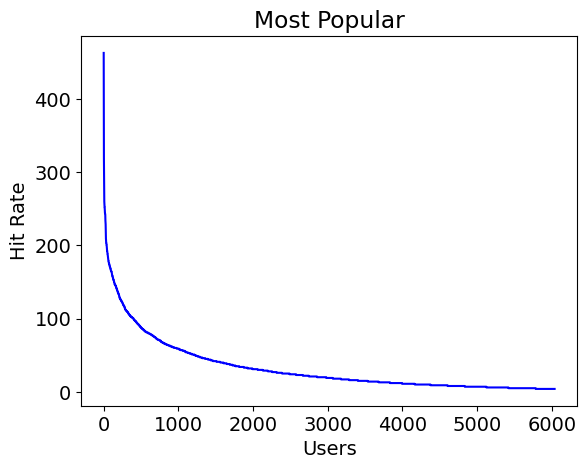

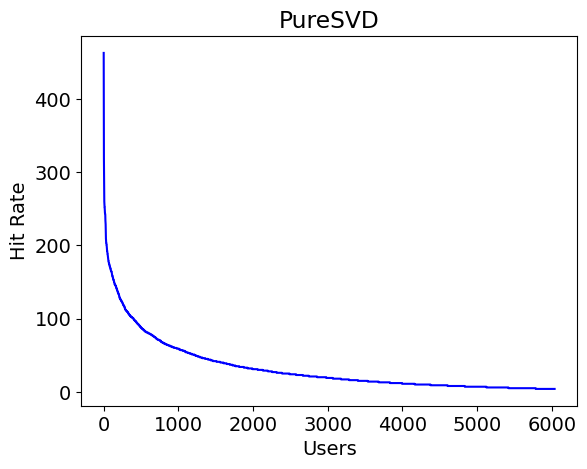

In [23]:
plotDistribution(list(hitRate_MP.values()), "Users", "Hit Rate", "Most Popular")
#plotDistribution(list(hitRate_BR.values()), "Users", "Hit Rate", "Best-Rated")
#plotDistribution(list(hitRate_Roc.values()), "Users", "Hit Rate", "Rocchio")
plotDistribution(list(hitRate_SVD.values()), "Users", "Hit Rate", "PureSVD")

#### Measuring precision and recall

In [24]:
precision_MP, recall_MP = metric_precision_recall(users_targets, test_matrix, rec_MostPopular)
precision_BR, recall_BR = metric_precision_recall(users_targets, test_matrix, rec_BestRated)
precision_Roc, recall_Roc = metric_precision_recall(users_targets, test_matrix, rec_Rocchio)
precision_SVD, recall_SVD = metric_precision_recall(users_targets, test_matrix, rec_PureSVD)

**Precision**: Analyzing min, max, average, median and std.

In [25]:
statisticInformation(list(precision_MP.values()), "Most-Popular")
statisticInformation(list(precision_BR.values()), "Best-Rated")
statisticInformation(list(precision_Roc.values()), "Rocchio")
statisticInformation(list(precision_SVD.values()), "PureSVD")

RS: Most-Popular
	- Min: 0.1
	- Max: 31.4
	- Mean: 1.7886920529801327
	- Median: 1.0
	- STD: 2.1724759910431
RS: Best-Rated
	- Min: 0.1
	- Max: 31.4
	- Mean: 1.7886920529801327
	- Median: 1.0
	- STD: 2.1724759910431
RS: Rocchio
	- Min: 0.1
	- Max: 31.4
	- Mean: 1.7886920529801327
	- Median: 1.0
	- STD: 2.1724759910431
RS: PureSVD
	- Min: 0.1
	- Max: 31.4
	- Mean: 1.7886920529801327
	- Median: 1.0
	- STD: 2.1724759910431


**Recall:** Analyzing min, max, average, median and std.

In [26]:
statisticInformation(list(recall_MP.values()), "Most-Popular")
statisticInformation(list(recall_BR.values()), "Best-Rated")
statisticInformation(list(recall_Roc.values()), "Rocchio")
statisticInformation(list(recall_SVD.values()), "PureSVD")

RS: Most-Popular
	- Min: 1.0
	- Max: 1.0
	- Mean: 1.0
	- Median: 1.0
	- STD: 0.0
RS: Best-Rated
	- Min: 1.0
	- Max: 1.0
	- Mean: 1.0
	- Median: 1.0
	- STD: 0.0
RS: Rocchio
	- Min: 1.0
	- Max: 1.0
	- Mean: 1.0
	- Median: 1.0
	- STD: 0.0
RS: PureSVD
	- Min: 1.0
	- Max: 1.0
	- Mean: 1.0
	- Median: 1.0
	- STD: 0.0


### Answer some questions!

**Questão 1:** Suponha que você foi contratado para uma empresa de e-commerce para utilizar propor um recomendador que maximize o número de vendas. Ele não está interessado em satisfazer ao cliente, mas apenas em vender. Qual dos recomendadores já implementados você sugere e por quê? Comprove com uma análise sua proposta.

In [ ]:
Hit Rate => Pure SVD

**Questão 2:** Em uma última análise do sistema, foi constatado que a maioria dos usuários gastam muito tempo até comprar um produto (desconsiderando o tempo de compra e escolha). Você consegue imaginar o porquê disso? Como você poderia avaliar se o recomendador está contribuindo para esse problema? Qual dos propostos anteriormente você sugeriria? Mostre a análise realizada.

In [ ]:
MRR => Pure SVD

**Questão 3:** Em todo sistema existem diferentes grupos de perfis dos usuários. Um exemplo clássico são os usuários que preferem os produtos populares (i.e., que estão na moda) e os que não consomem itens populares. 

a) Em geral, para qual deles é mais fácil acertar as recomendações? Por quê?

b) Se no seu sistema existem mais usuários com preferências por não populares, qual recomendador (dentre os implementados) você sugeriria? Mostre uma análise que comprove sua teoria.

---------------
Dica: Existem duas análises interessantes para esse problema. 
1. Medir métricas como novidade e diversidade dos itens recomendados, uma vez que elas tendem a mensurar o quão não-popular são os itens. Existem frameworks prontos com essas métricas. Aqui estão dois exemplos:
    - https://github.com/RankSys/RankSys/wiki/Novelty-and-Diversity
    - https://github.com/dcomp-labPi/FAiR 
2. É possível separar os usuários em três grupos: (1) os que tem no seu histórico mais 70% de itens populares; (2) os que possuem menos de 30% de itens populares consumidos; e (3) os que estão entre essas faixas de valores. Você pode fazer isso, simplesmente contando quantos itens de cada usuário estão no top-100 mais populares. Definido isso, basta re-avaliar os recomendadores sobre os usuários do grupo (2). Assim você conseguirá ver o desempenho deles.

In [ ]:
Usuários que preferem produtos populares